In [108]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/denver-listings/Denver_listings.csv


# In this notebook we will be using the majority classifier class model to classify the neighbourhood groups from Denver based on their amount of reviews reviews and their correlation with the room types available within the Airbnb bookings dataset (fix title when done with project)

In [131]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot') # makes the plots look better

In [132]:
# Importing the necessary csv files 

data = pd.read_csv("/kaggle/input/denver-listings/Denver_listings.csv")

# Within the next two tables, we're looking at the first 5 rows for both Denver's dataset

In [133]:
# Looking at the first 5 rows for Denver's dataset

data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,360,Sit in the Peaceful Garden of the Chickadee Co...,666,Jennifer & Giovanni,NaN,Highland,39.766415,-105.002098,Entire home/apt,161.0,30,181,2024-03-02,2.53,2,110,3,2017-BFN-0002177
1,364,Lodo / RiNo LOFT via airport train,783,Jason,NaN,Five Points,39.766720,-104.979060,Entire home/apt,179.0,185,87,2016-04-26,0.47,1,358,0,NaN
2,590,Comfortable - and a great value!,933,Jill,NaN,North Park Hill,39.755110,-104.911090,Private room,70.0,1,726,2024-05-22,3.91,2,236,24,2021-BFN-0000578
3,592,private,933,Jill,NaN,North Park Hill,39.754810,-104.911060,Private room,64.0,15,175,2024-06-02,0.94,2,219,7,2021-BFN-0000578
4,1940,Baker Studio: Private-full kitchen-W/D-walkable,2150,Joanne,NaN,Baker,39.720205,-104.997499,Entire home/apt,88.0,1,183,2024-06-27,2.02,1,231,51,2018-BFN-0002596


# Within the next two tables, we're looking at the calculated descriptive statistics for both Denvers' and Seatle's datasets

In [134]:
# Looking at the calculated descriptive statistics for each column within the dataset for Denver

data.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,5.016000e+03,5.016000e+03,0.0,5016.000000,5016.000000,4638.000000,5016.000000,5016.000000,4393.000000,5016.000000,5016.000000,5016.000000
mean,4.808710e+17,1.581792e+08,NaN,39.742546,-104.976528,382.726822,15.402711,62.196172,1.951974,7.831738,185.214912,14.974083
std,4.614996e+17,1.708323e+08,NaN,0.031773,0.061273,4064.858584,20.293866,109.832777,2.062880,18.289987,118.205523,21.683763
min,3.600000e+02,5.890000e+02,NaN,39.626588,-105.102804,17.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,3.994188e+07,2.378105e+07,NaN,39.728818,-105.017746,95.000000,2.000000,3.000000,0.370000,1.000000,78.000000,1.000000
50%,6.137098e+17,8.033043e+07,NaN,39.749547,-104.985150,138.000000,3.000000,18.000000,1.330000,1.000000,181.000000,5.000000
75%,9.201500e+17,2.526839e+08,NaN,39.763063,-104.959073,219.000000,29.000000,74.000000,2.880000,3.000000,302.000000,22.000000
max,1.189315e+18,5.857442e+08,NaN,39.847417,-104.673817,99713.000000,500.000000,1529.000000,25.800000,97.000000,365.000000,314.000000


# In the graphs below we're looking at a visual that will show us the correlation between the prices and the reviews that have been conducted per month and also for their room types

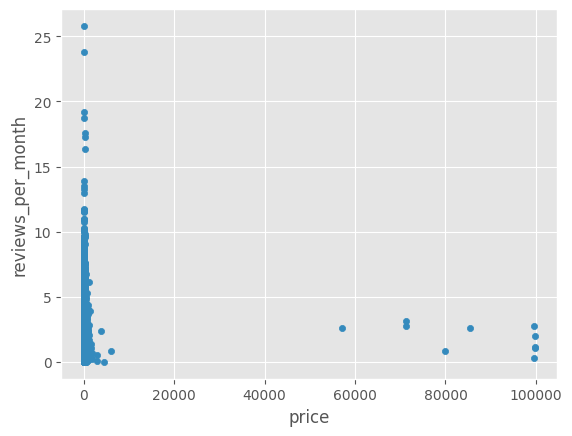

In [135]:
# Graph for Denver

data.plot.scatter(x='price', y='reviews_per_month')

plt.show()

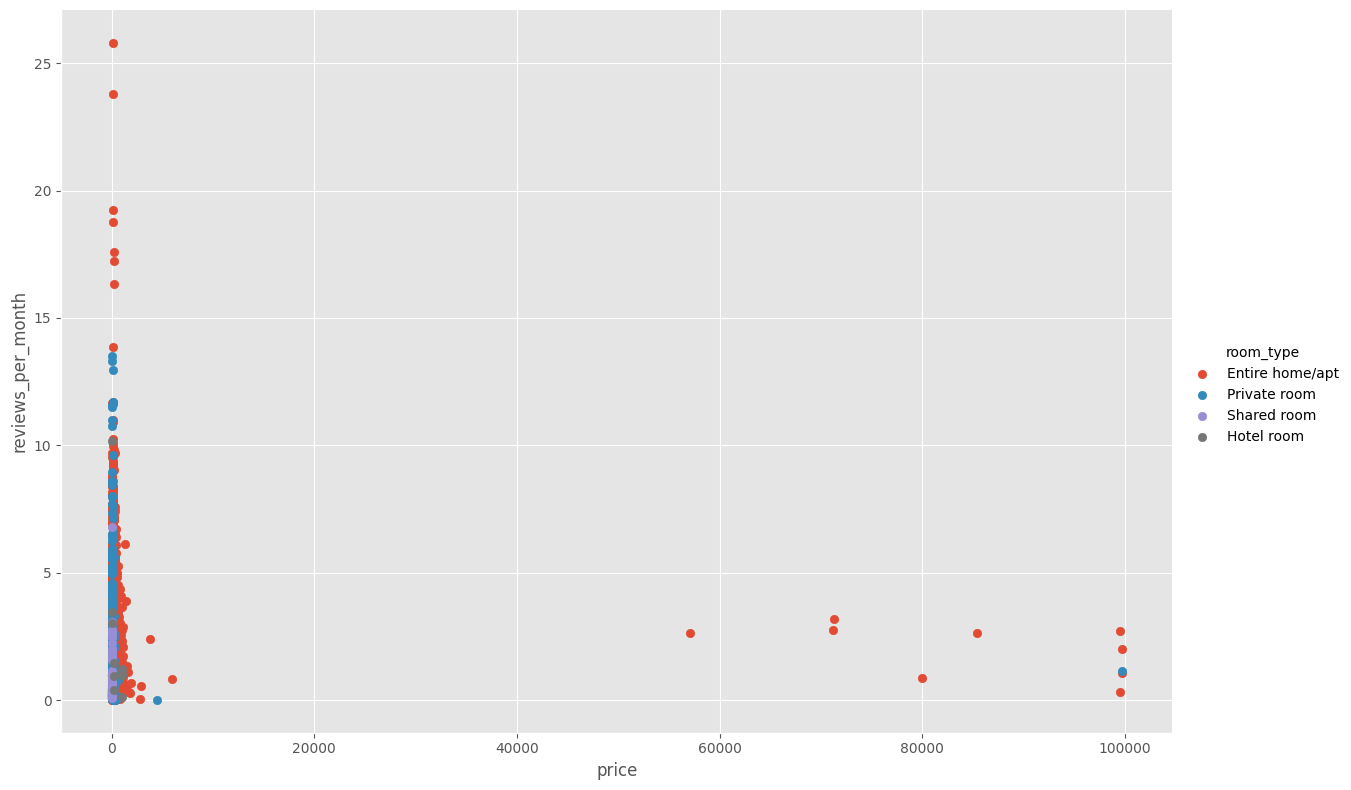

In [136]:
# Graph for Denver

sns.FacetGrid(data, hue="room_type", height=8, aspect=1.5) \
   .map(plt.scatter, 'price', 'reviews_per_month') \
   .add_legend()

plt.show()

# Now we will be prepping the dataset, so that we only have to worry about the categories that matters 

In [143]:
# Keeping only relevant columns
data = data[['price', 'reviews_per_month', 'room_type']]

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Impute missing values with the mean
data[['price', 'reviews_per_month']] = imputer.fit_transform(data[['price', 'reviews_per_month']])

# Encode the target variable (`room_type`) as numbers
label_encoder = LabelEncoder()
data['room_type'] = label_encoder.fit_transform(data['room_type'])

# We will be splitting the data to train and test

In [144]:
# Train-Test Split
X = data[['price', 'reviews_per_month']]  # Features
y = data['room_type']                     # Target

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the RandomForestClassifier

In [147]:
# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [148]:
# Make Predictions and Evaluate
y_pred = clf.predict(X_test)

# Making the predictions and seeing the results 

In [149]:
# Print classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8735059760956175

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       856
           1       1.00      0.57      0.73         7
           2       0.56      0.41      0.47       133
           3       1.00      0.38      0.55         8

    accuracy                           0.87      1004
   macro avg       0.87      0.58      0.67      1004
weighted avg       0.86      0.87      0.86      1004

